In [79]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from joblib import dump,load
import os

def download_data(tickers,start,end):
    data=yf.download(tickers,start=start,end=end)
    data=data.stack().reset_index()
    data.drop(columns=["Close","Open","High","Low","Volume"],inplace=True)
    data.rename(columns={"level_1":"ticker","Date":"date","Adj Close":"close"},inplace=True)
    return data

def preprocess_data(df):
    df["return"]=df.groupby("ticker")["close"].pct_change()
    df["date"]=pd.to_datetime(df["date"])
    return df

#kelly fractions calculated daily using 2y rolling window

#uses closed form approximation of fractions from Positional Options Trading book
def noncorrelated_kelly(df,window=504):
    df["kelly_fraction"] = df.groupby("ticker")["return"].transform(
        lambda x: x.shift(1).rolling(window=window).apply(calculate_kelly_fraction,raw=False))
    df = df.groupby('date').apply(normalize_fractions)
    return df

def calculate_kelly_fraction(x):
    mean = x.mean()
    std = x.std()
    if std > 0:
        skew = ((x - mean)**3).mean() / std**3
    else:
        skew = pd.NA

    fraction = (mean / (mean**2 + std**2)) + ((skew*(mean**2)) / (mean**2 + std**2)**3)
    return fraction

def normalize_fractions(group):
    df["kelly_fraction"] = df["kelly_fraction"].fillna(0)
    group["kelly_fraction"]=group["kelly_fraction"].clip(lower=0)
    total_fraction = group["kelly_fraction"].sum()
    if total_fraction>1:
        group["kelly_fraction"] = group["kelly_fraction"] / total_fraction
    return group

#applies optimization from Frontiers paper https://www.frontiersin.org/articles/10.3389/fams.2020.577050/full
def correlated_kelly(df, start_year, window=252, use_total_balance=True):
    
    date_count = len(df["date"].unique())
    stock_dim = len(df["ticker"].unique())
    df['kelly_fraction']=0
    
    if use_total_balance:
        #sum of all fractions == 1
        constraints = [{'type': 'eq', 'fun': lambda F: np.sum(F)-1}]
    else:
        #sum of all fractions <=1
        constraints = [{'type': 'ineq', 'fun': lambda F: 1-np.sum(F)}]
        
    bounds = [(0,1) for _ in range(stock_dim)]
    F_initial = np.array([1/stock_dim]*stock_dim)
    
    rf_rate = .01/252

    for d in range(1,date_count-window):

        year = df.loc[end_idx,"date"].year
        if year <= start_year:
            continue
        else:
            
            start_idx = d*stock_dim
            end_idx = (d+window)*stock_dim
            temp = df.iloc[start_idx:end_idx]
            temp = temp.pivot(index="date",columns="ticker",values="return")
            
            cov = temp.cov().values
            mean = temp.mean().values
            inv_cov = np.linalg.inv(cov)
            r = np.array([rf_rate]*stock_dim)
        
            def objective(F):
                return -(rf_rate + F.T@(mean-r)-((1/2)*F.T@inv_cov@F))
        
            result = minimize(objective,F_initial,method="SLSQP",
                            bounds=bounds, constraints=constraints)
        
            if result["success"] == True:
                F=result["x"]
            else:
                print(f"Optimization could not be solved between indices {left_index},{right_index}")
                break
        
            #.loc is inclusive of right index, therefore subtract 1
            df.loc[end_idx:end_idx+stock_dim-1, 'kelly_fraction'] = F
    
            if end_idx%(stock_dim*252)==0:
                print("calculated up to: ",df["date"].iloc[end_idx])
        return df

def forecasted_correlated_kelly(df, start_year, lag, window=252, use_total_balance=True):
    
    date_count = len(df["date"].unique())
    stock_dim = len(df["ticker"].unique())
    df['kelly_fraction']=0
    
    if use_total_balance:
        #sum of all fractions == 1
        constraints = [{'type': 'eq', 'fun': lambda F: np.sum(F)-1}]
    else:
        #sum of all fractions <=1
        constraints = [{'type': 'ineq', 'fun': lambda F: 1-np.sum(F)}]
        
    bounds = [(0,1) for _ in range(stock_dim)]
    F_initial = np.array([1/stock_dim]*stock_dim)
    
    rf_rate = .01/252

    lagged_cov_matrices = []
    predicted_cholesky = []
    sse_cholesky_list = []
    dates = []
    
    for d in range(1,date_count-window):
        
        start_idx = d*stock_dim
        end_idx = (d+window)*stock_dim

        year = df.loc[end_idx,"date"].year

        temp = df.iloc[start_idx:end_idx]
        temp = temp.pivot(index="date",columns="ticker",values="return")
        hist_cov_matrix = temp.cov().values
        lagged_cov_matrices.append(hist_cov_matrix)
        
        if len(lagged_cov_matrices) > lag:
            del lagged_cov_matrices[0]

        if year <= start_year or len(lagged_cov_matrices)<lag:
            continue
        else:
            mean = temp.mean().values
            r = np.array([rf_rate]*stock_dim)
            
            pred_cov_matrix = forecast_cov_matrix(lagged_cov_matrices,predicted_cholesky,year,lag)
            inv_pred_cov_matrix = np.linalg.inv(pred_cov_matrix)

            start_idx2 = start_idx + stock_dim
            end_idx2 = end_idx + stock_dim
            temp2 = df.iloc[start_idx2:end_idx2]
            temp2 = temp2.pivot(index="date",columns="ticker",values="return")
            actual_col_matrix = temp2.cov().values
            rows, cols = np.tril_indices(actual_col_matrix.shape[0])
            cholesky_factor = np.linalg.cholesky(actual_col_matrix)
            entry_row = cholesky_factor[rows, cols]
            sse_cholesky = ((predicted_cholesky[-1] - entry_row)**2).sum()
            sse_cholesky_list.append(sse_cholesky)
            dates.append(df.loc[end_idx2-1,"date"])

        
            def objective(F):
                return -(rf_rate + F.T@(mean-r)-((1/2)*F.T@inv_pred_cov_matrix@F))
        
            result = minimize(objective,F_initial,method="SLSQP",
                            bounds=bounds, constraints=constraints)
        
            if result["success"] == True:
                F=result["x"]
            else:
                print(f"Optimization could not be solved between indices {left_index},{right_index}")
                break
        
            #.loc is inclusive of right index, therefore subtract 1
            df.loc[end_idx:end_idx+stock_dim-1, 'kelly_fraction'] = F
    
            if end_idx%(stock_dim*252)==0:
                print("calculated up to: ",df["date"].iloc[end_idx])

    error_df = pd.DataFrame(sse_cholesky_list, index=dates, columns=['sse_cholesky'])
    error_df.to_csv("sse_cholesky.csv")
    
    return df


def forecast_cov_matrix(matrix_list, pred_cholesky_list, year, lag):

    if len(matrix_list) < 1:
        print("No matrices avaiable to forecast with")
    else:
        matrix_dim = matrix_list[0].shape[0]
        rows, cols = np.tril_indices(matrix_dim)
        
        entry_matrix = []
        for cov_matrix in matrix_list:
            cholesky_factor = np.linalg.cholesky(cov_matrix)
            entry_row = cholesky_factor[rows, cols]
            entry_matrix.append(entry_row)
        entry_df = pd.DataFrame(entry_matrix)
    
        pred_entry_row = []
        path = fr"hist_cf_entry_svr_models_lag_{lag}\\{year}"
        for col in entry_df.columns:
            model_path = path + fr"\svr_model_entry_{col}.joblib"
            loaded_model = load(model_path)
            pred = loaded_model.predict(entry_df[col].values.reshape(1, -1))
            pred_entry_row.append(pred[0])

        pred_matrix = np.zeros((matrix_dim, matrix_dim))
        pred_matrix[rows, cols] = np.array(pred_entry_row)
        pred_cholesky_list.append(np.array(pred_entry_row))

        return pred_matrix

def daily_return(group):
    a=(group["return"] * group["kelly_fraction"]).sum()
    return a

def backtest_kelly(df, tick_dict, initial=1000000):
    port_returns = df.groupby("date").apply(daily_return).reset_index(name="port_return")
    trade_df = pd.DataFrame()
    trade_df["date"] = port_returns["date"]
    trade_df["port_return"] = port_returns["port_return"]
    trade_df["port_value"] = initial * ((1+trade_df["port_return"]).cumprod())
    
    return trade_df

def portfolio_performance(df,return_col,value_col,rfr="^TNX",interval=252):
    start_date = df["date"].iloc[0]
    end_date = df["date"].iloc[-1]

    years = (start_date-end_date).days / interval
    
    mean_return = df[return_col].mean()
    std_return = df[return_col].std()
    start_value = df[value_col].iloc[0]
    end_value = df[value_col].iloc[-1]
    total_return = (end_value - start_value)/end_value
    annualized_return = ((1+total_return)**(1/years)) - 1
    sharpe, annualized_sharpe = calculate_sharpe(df,return_col,rfr,interval) 
    max_drawdown = df[return_col].min()

    print(f"mean return: {mean_return}")
    print(f"std return: {std_return}")
    print(f"max drawdown: {max_drawdown}")
    print(f"total return: {total_return}")
    print(f"annualized return: {annualized_return}")
    print(f"sharpe: {sharpe}")
    print(f"annualized sharpe: {annualized_sharpe}")


def calculate_sharpe(df,return_col,rfr='^TNX',interval=252):
    start_date = df["date"].iloc[0]
    end_date = df["date"].iloc[-1]
    
    data = yf.download(rfr, start=start_date, end=end_date)
    data=data.reset_index()
    rate_df = pd.DataFrame()
    rate_df[["date","rate"]] = data[["Date","Adj Close"]]
    port_df = pd.DataFrame()
    port_df[["date","return"]] = df[["date",return_col]] 
    temp_df = pd.merge(port_df,rate_df,on="date",how="outer")
    temp_df["rate"]=temp_df["rate"].fillna(method="ffill")
    temp_df["rate"] = (temp_df["rate"]/interval)/100

    sharpe = ((temp_df["return"]-(.01/252)).mean()) / temp_df["return"].std()
    annualized_sharpe = sharpe * np.sqrt(interval)

    return sharpe,annualized_sharpe

def plot_performance(df):
    plt.plot(df['date'], df['port_value'])
    plt.title('Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Value ($millions)')
    plt.show()

    cum_return1 = (df["port_return"]).cumsum()
    cum_return2 = (1+df["port_return"]).cumprod()

    fig, axs = plt.subplots(1,2,figsize=(12,5))

    axs[0].plot(df['date'], cum_return1)
    axs[0].set_title('Portfolio Cumulative Return (CumSum)')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Return')
    
    axs[1].plot(df['date'], cum_return2)
    axs[1].set_title('Portfolio Cumulative Return (CumProd)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Return')
    
    plt.tight_layout()
    plt.show()


In [2]:
#present day DJIA constituents and dates they were added
dow_tickers = [
    "MMM", "AXP", "AMGN", "AMZN", "AAPL", 
    "BA", "CAT", "CVX", "CSCO", "KO", 
    "DIS", "DOW", "GS", "HD", "HON", 
    "IBM", "INTC", "JNJ", "JPM", "MCD", 
    "MRK", "MSFT", "NKE", "PG", "CRM", 
    "TRV", "UNH", "VZ", "V", "WMT"
]

dow_dates = [
    '1976-08-09','1982-08-30','2020-08-31','2024-02-26',
    '2015-03-19','1987-03-12','1991-05-06','2008-02-19',
    '2009-06-08','1987-03-12','1991-05-06','1991-05-06',
    '2019-04-02','1999-11-01','2020-08-31','1979-06-29',
    '1999-11-01','1997-03-17','1991-05-06','1985-10-30',
    '1979-06-29','1999-11-01','2013-09-20','1932-05-26',
    '2020-08-31','2009-06-08','2012-09-24','2004-04-08',
    '2013-09-20','1997-03-17']

dow_constituents = dict(zip(dow_tickers,dow_dates))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#tickers in DJIA on Oct-31-2004, excludes tickers that became inactive

tickers = ['WMT', 'INTC', 'MSFT', 'KO', 'PG', 'AXP', 'IBM', 'MCD', 'JNJ', 'DIS', 'CAT', 'HD', 'MRK', 'MMM', 'BA', 'VZ', 'JPM', 'HON', 'T', 'HPQ', 'RTX', 'PFE', 'GE', 'AIG', 'MO', 'C', 'XOM']

In [4]:
start = '2005-01-01'
end = '2023-12-31'

In [5]:
initial_balance = 1000000

In [6]:
 df = download_data(tickers,start,end)

[*********************100%%**********************]  27 of 27 completed


In [7]:
df1=preprocess_data(df)

In [36]:
kelly_1 = noncorrelated_kelly(df1,window=504)

C:\Users\wvill\AppData\Local\Temp\ipykernel_25064\3998496289.py:25: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('date').apply(normalize_fractions)


In [65]:
kelly_2 = correlated_kelly(df1,window=252,use_total_balance=True)

calculated up to:  2007-01-04 00:00:00
calculated up to:  2008-01-04 00:00:00
calculated up to:  2009-01-05 00:00:00
calculated up to:  2010-01-05 00:00:00
calculated up to:  2011-01-04 00:00:00
calculated up to:  2012-01-04 00:00:00
calculated up to:  2013-01-07 00:00:00
calculated up to:  2014-01-07 00:00:00
calculated up to:  2015-01-07 00:00:00
calculated up to:  2016-01-07 00:00:00
calculated up to:  2017-01-06 00:00:00
calculated up to:  2018-01-08 00:00:00
calculated up to:  2019-01-09 00:00:00
calculated up to:  2020-01-09 00:00:00
calculated up to:  2021-01-08 00:00:00
calculated up to:  2022-01-07 00:00:00
calculated up to:  2023-01-10 00:00:00


In [68]:
kelly_3 = correlated_kelly(df1,window=504,use_total_balance=False)

calculated up to:  2008-01-04 00:00:00
calculated up to:  2009-01-05 00:00:00
calculated up to:  2010-01-05 00:00:00
calculated up to:  2011-01-04 00:00:00
calculated up to:  2012-01-04 00:00:00
calculated up to:  2013-01-07 00:00:00
calculated up to:  2014-01-07 00:00:00
calculated up to:  2015-01-07 00:00:00
calculated up to:  2016-01-07 00:00:00
calculated up to:  2017-01-06 00:00:00
calculated up to:  2018-01-08 00:00:00
calculated up to:  2019-01-09 00:00:00
calculated up to:  2020-01-09 00:00:00
calculated up to:  2021-01-08 00:00:00
calculated up to:  2022-01-07 00:00:00
calculated up to:  2023-01-10 00:00:00


In [37]:
kelly_4 = forecasted_correlated_kelly(df1,2007,15,window=252,use_total_balance=True)

calculated up to:  2008-01-04 00:00:00
calculated up to:  2009-01-05 00:00:00
calculated up to:  2010-01-05 00:00:00
calculated up to:  2011-01-04 00:00:00
calculated up to:  2012-01-04 00:00:00
calculated up to:  2013-01-07 00:00:00
calculated up to:  2014-01-07 00:00:00
calculated up to:  2015-01-07 00:00:00
calculated up to:  2016-01-07 00:00:00
calculated up to:  2017-01-06 00:00:00
calculated up to:  2018-01-08 00:00:00
calculated up to:  2019-01-09 00:00:00
calculated up to:  2020-01-09 00:00:00
calculated up to:  2021-01-08 00:00:00
calculated up to:  2022-01-07 00:00:00
calculated up to:  2023-01-10 00:00:00


In [38]:
kelly_4.to_csv("kelly_4.csv")

In [59]:
sse_cholesky=pd.read_csv("sse_cholesky.csv")
sse_cholesky.rename(columns={"Unnamed: 0":"date"},inplace=True)
sse_cholesky["date"] = pd.to_datetime(sse_cholesky["date"])
sse_cholesky.set_index("date",inplace=True)

In [63]:
trade_4 = backtest_kelly(kelly_4,tickers,initial_balance)
    

In [64]:
portfolio_performance(trade_4,"port_return","port_value","^TNX",252)

[*********************100%%**********************]  1 of 1 completed
mean return: 0.00044125437780717126
std return: 0.015111209907986218
max drawdown: -0.15140260029032424
total return: 0.7905771130448632
annualized return: -0.020948447268903436
sharpe: 0.026574433190316687
annualized sharpe: 0.4218560487244725


In [39]:
trade_1 = backtest_kelly(kelly_1,tickers,initial_balance)

In [77]:
trade_2 = backtest_kelly(kelly_2_2,tickers,initial_balance)

In [73]:
kelly_2_2 = kelly_2[kelly_2["date"].apply(lambda x: x.year >=2007)]

In [69]:
trade_3 = backtest_kelly(kelly_3,tickers,initial_balance)

In [75]:
portfolio_performance(trade_1,"port_return","port_value","^TNX",252)

[*********************100%%**********************]  1 of 1 completed
mean return: 0.0003689997781250129
std return: 0.010391136232077111
max drawdown: -0.08858533293578934
total return: 0.7782703201875429
annualized return: -0.020703018585134902
sharpe: 0.024702282847243785
annualized sharpe: 0.3921365833763016


In [78]:
portfolio_performance(trade_2,"port_return","port_value","^TNX",252)

[*********************100%%**********************]  1 of 1 completed
mean return: 0.0004930409243762276
std return: 0.015102726716341842
max drawdown: -0.12500021413740792
total return: 0.8015447598143246
annualized return: -0.023626542256104388
sharpe: 0.0300183134614449
annualized sharpe: 0.47652595317939417


In [77]:
portfolio_performance(trade_3,"port_return","port_value","^TNX",252)

[*********************100%%**********************]  1 of 1 completed
mean return: 2.463540707225743e-07
std return: 8.071350642918494e-06
max drawdown: -0.00014467522020521033
total return: 0.0011769698044529384
annualized return: -4.274814670712779e-05
sharpe: -13.884744041395766
annualized sharpe: -220.41347850791468


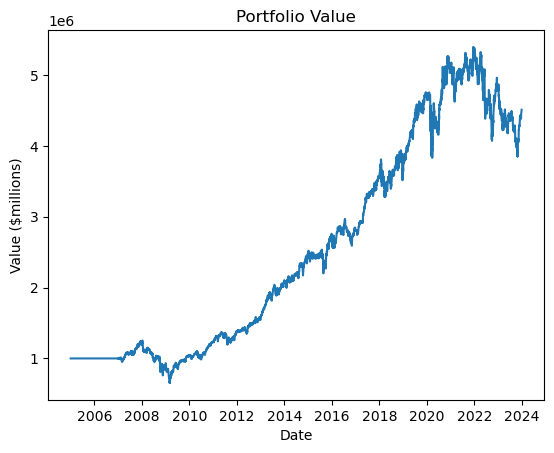

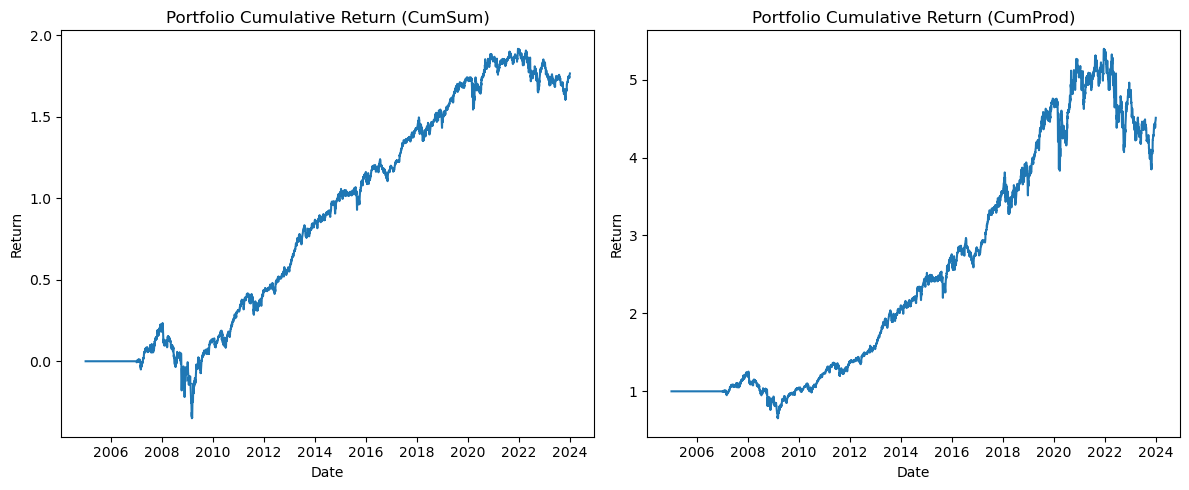

In [71]:
plot_performance(trade_1)

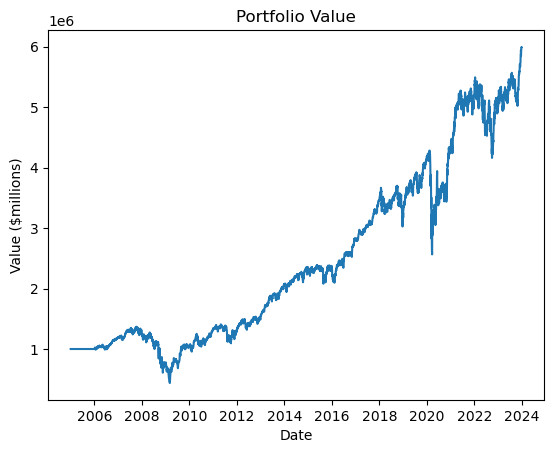

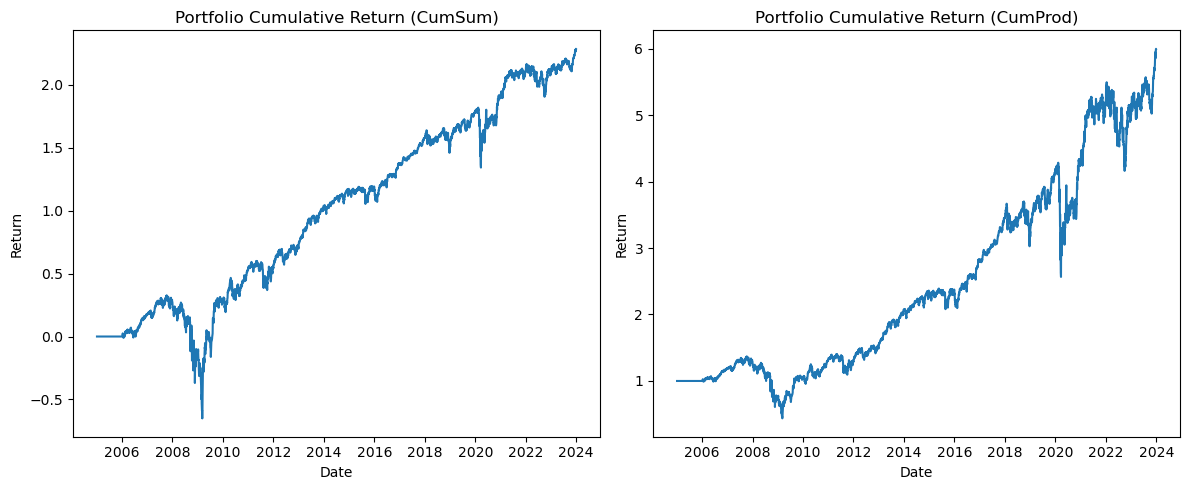

In [94]:
plot_performance(trade_2)

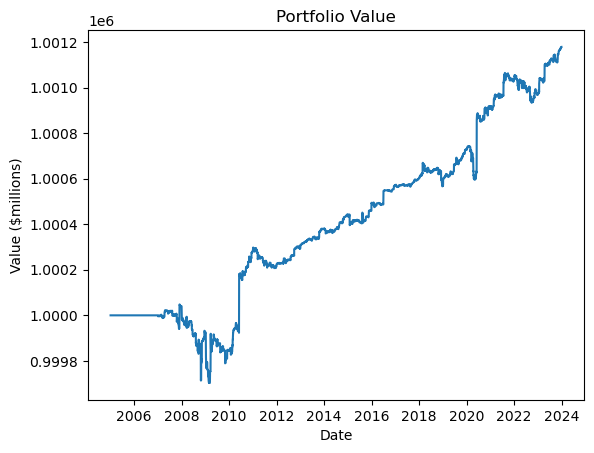

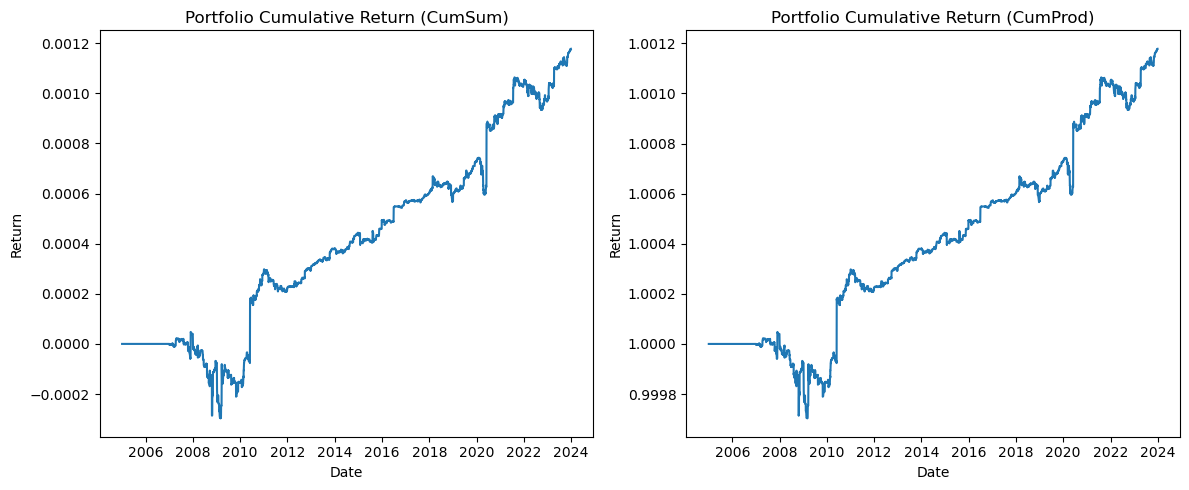

In [73]:
plot_performance(trade_3)

## google doc tasks

In [2]:
def create_autoregressive_data_df(series, lag):
    column_names = [f"t-{lag-i}" for i in range(0,lag)] + ["t"]
    data_df = pd.DataFrame(columns = column_names)
    for i in range(lag,len(series)):
        window_array = np.array(series[i-lag:i+1]).reshape(1,-1)
        window_df = pd.DataFrame(window_array,columns=data_df.columns)
        data_df = pd.concat([data_df,window_df])
    data_df.index = series[lag:].index

    return data_df

def save_entry_data(df, entry, year,lag):
    path = os.path.join(f"hist_cf_entry_ar_data_lag_{lag}",
                       f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)

    csv_path = os.path.join(path, f"cholesky_factor_entry_{entry}.csv")
    df.to_csv(csv_path)

class HistoricalCholesky:

    
    def __init__(self, df=None, cov_window=252, autoregressive_lag=1, retraining_interval="y"):
        
        self.stock_df = df
        self.cov_window = cov_window
        self.autoregressive_lag = autoregressive_lag
        #do not do following lines on initialization
        self.total_hist_cholesky_df = self.get_historical_cholesky(self.stock_df)
        if retraining_interval == "y":
            self.hist_cholesky_data = self.yearly_data_split(self.total_hist_cholesky_df)

        self.cf_entry_autoregressive_data = self.get_cf_entry_autoregressive_data()
        self.model_dict = get_cholesky_models()
        
        
    
    def get_historical_cholesky(self, df=None):
        
        date_count = len(df["date"].unique())
        stock_dim = len(df["ticker"].unique())
        entries_df = pd.DataFrame()
        for d in range(1,date_count-self.cov_window+1):
            start_idx = d*stock_dim
            end_idx = (d+self.cov_window)*stock_dim
            temp = df.iloc[start_idx:end_idx]
            temp = temp.pivot(index="date",columns="ticker",values="return")
            cov = temp.cov().values
            cholesky_factor = np.linalg.cholesky(cov).T
            entries = []
            for i in range(stock_dim):
                for j in range(i+1):
                    entries.append(cholesky_factor[j,i])
            row = np.array(entries).reshape(1, -1)
            row_df = pd.DataFrame(row)
            row_df["date"] = pd.to_datetime(temp.index[-1])
            row_df.set_index("date",inplace=True)
            entries_df = pd.concat([entries_df,row_df],axis=0)
        
        return entries_df

    
    def yearly_data_split(self, df):

        #check if df type is actually DataFrame if not return error
        data_dict = {}
        year_keys = list(df.index.year.unique())
        for year in year_keys:
            data_dict[year] = df[df.index.year <= year]
            
        return data_dict


    def get_cf_entry_autoregressive_data(self):
        years = list(self.hist_cholesky_data.keys())
        data_dict = {}
        for year in years:
            print(f"producing autoregressive data for entries in year: {year}")
            entry_list = list(self.hist_cholesky_data[year].columns)
            entry_data_list = []
            for entry in entry_list:
                print(f"producing autoregressive data for entry: {entry}, year: {year}")
                entry_data = create_autoregressive_data_df(series = self.hist_cholesky_data[year][entry],
                                                          lag = self.autoregressive_lag)
                entry_data_list.append(entry_data)
                save_entry_data(entry_data,entry,year,self.autoregressive_lag)

            data_sub_dict = dict(zip(entry_list, entry_data_list))

            data_dict[year] = data_sub_dict
        return data_dict


    
        

In [9]:
hc = HistoricalCholesky(df1,252,15,"y")

In [10]:
full = hc.hist_cholesky_data

In [14]:
path1 = os.path.join("hist_cholesky_data")
for year in range(2006,2024):
    
    if not os.path.exists(path1):
        os.makedirs(path1,exist_ok=True)

    csv_path = os.path.join(path1, f"hist_cholesky_data_{year}.csv")
    full[year].to_csv(csv_path)

In [4]:
full = {}
for year in range(2006,2024):
    df=pd.read_csv(fr"C:\Users\wvill\OneDrive\FQE\2024\Spring 2024\Projects\portfolio_optimization\hist_cholesky_data\hist_cholesky_data_{year}.csv")
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date",inplace=True)
    full[year]=df
    

In [11]:
large_dict = {}
for year in range (2006,2024):
    sub_dict = {}
    print(f"on year {year}")
    for entry in range(378):
        print(f"on entry {entry}, year {year}")
        df = pd.read_csv(fr"C:\Users\wvill\OneDrive\FQE\2024\Spring 2024\Projects\portfolio_optimization\hist_cf_entry_ar_data_lag_15\\{year}\cholesky_factor_entry_{entry}.csv")
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date",inplace=True)
        sub_dict[entry]=df
    large_dict[year]=sub_dict
        

on year 2006
on entry 0, year 2006
on entry 1, year 2006
on entry 2, year 2006
on entry 3, year 2006
on entry 4, year 2006
on entry 5, year 2006
on entry 6, year 2006
on entry 7, year 2006
on entry 8, year 2006
on entry 9, year 2006
on entry 10, year 2006
on entry 11, year 2006
on entry 12, year 2006
on entry 13, year 2006
on entry 14, year 2006
on entry 15, year 2006
on entry 16, year 2006
on entry 17, year 2006
on entry 18, year 2006
on entry 19, year 2006
on entry 20, year 2006
on entry 21, year 2006
on entry 22, year 2006
on entry 23, year 2006
on entry 24, year 2006
on entry 25, year 2006
on entry 26, year 2006
on entry 27, year 2006
on entry 28, year 2006
on entry 29, year 2006
on entry 30, year 2006
on entry 31, year 2006
on entry 32, year 2006
on entry 33, year 2006
on entry 34, year 2006
on entry 35, year 2006
on entry 36, year 2006
on entry 37, year 2006
on entry 38, year 2006
on entry 39, year 2006
on entry 40, year 2006
on entry 41, year 2006
on entry 42, year 2006
on entry

In [12]:
temp = large_dict[2006][0]

In [137]:
pop=[(year,dict) for year,dict in large_dict.items()]

In [170]:
full_dict = get_cf_entry_autoregressive_data(full,15)

starting
producing autoregressive data for entries in year: 2006
producing autoregressive data for entry: 0, year: 2006
producing autoregressive data for entry: 1, year: 2006
producing autoregressive data for entry: 2, year: 2006
producing autoregressive data for entry: 3, year: 2006
producing autoregressive data for entry: 4, year: 2006
producing autoregressive data for entry: 5, year: 2006
producing autoregressive data for entry: 6, year: 2006
producing autoregressive data for entry: 7, year: 2006
producing autoregressive data for entry: 8, year: 2006
producing autoregressive data for entry: 9, year: 2006
producing autoregressive data for entry: 10, year: 2006
producing autoregressive data for entry: 11, year: 2006
producing autoregressive data for entry: 12, year: 2006
producing autoregressive data for entry: 13, year: 2006
producing autoregressive data for entry: 14, year: 2006
producing autoregressive data for entry: 15, year: 2006
producing autoregressive data for entry: 16, year

In [119]:
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from joblib import dump,load
import os

In [141]:
def save_svr_gridsearch_results(df,year,entry,lag):
    
    path = os.path.join(f"hist_cf_entry_svr_gridsearch_results_lag_{lag}",
                       f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)
        
    csv_path = os.path.join(path, f"svr_gridsearch_results_entry_{entry}.csv")
    df.to_csv(csv_path)

def save_svr_model(model, year, entry, lag):

    path = os.path.join(f"hist_cf_entry_svr_models_lag_{lag}",
                        f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)
                              
    model_path = os.path.join(path,f"svr_model_entry_{entry}.joblib")
    
    dump(model, model_path)

def get_best_svr_model(results_df, X_train, X_test, y_train, y_test):
    
    best_params_df = results_df[results_df['mean_test_score'] == results_df['mean_test_score'].max()].reset_index(drop=True)
    test_mse_list = []
    best_params_list = list(best_params_df["params"])
    
    for params in best_params_list:
        temp_model = SVR(**params)
        temp_model.fit(X_train,y_train)
        y_pred = temp_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        test_mse_list.append(test_mse)
        
    best_idx = test_mse_list.index(min(test_mse_list))
    best_params = best_params_list[best_idx]
    best_model = SVR(**best_params)
    
    return best_model

def generate_svr_models(large_dict,lag):

    model_dict = {}
    for year, cf_entry_dict in large_dict.items():
        print(f"generating models for entries in year: {year}")

        sub_dict = {}
        for entry, entry_data in cf_entry_dict.items():
            print(f"generating models for entry: {entry}, year: {year}")
            tscv = TimeSeriesSplit(n_splits=5)
            
            #expansion of paramter grid used in https://link.springer.com/article/10.1007/s10489-021-02217-5
            gridsearch_params = {
                'C': [2**i for i in range(-10,11)],  # Example values, adjust based on your needs
                'epsilon': [2**i for i in range(-10,11)]  # Example values
            }
            #gaussian kernel used
            gridsearch = GridSearchCV(SVR(kernel = "rbf"),gridsearch_params,cv=tscv,scoring='neg_mean_squared_error')
        
            X = entry_data[[f"t-{i}" for i in range(lag,0,-1)]]
            y = entry_data["t"]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
            
            gridsearch.fit(X_train,y_train)
            results = pd.DataFrame(gridsearch.cv_results_)
            save_svr_gridsearch_results(results, year, entry, lag)
            
            final_model = get_best_svr_model(results, X_train, X_test, y_train, y_test)
            final_model.fit(X,y)
            save_svr_model(final_model, year, entry, lag)
            sub_dict[entry]=final_model
        #models trained over year-t,...,year will be use for forecasting in year+1
        model_dict[year+1]=sub_dict
    return model_dict
            

In [142]:
model_dict = generate_svr_models(large_dict,15)

generating models for entries in year: 2006
generating models for entry: 0, year: 2006
generating models for entry: 1, year: 2006
generating models for entry: 2, year: 2006
generating models for entry: 3, year: 2006
generating models for entry: 4, year: 2006
generating models for entry: 5, year: 2006
generating models for entry: 6, year: 2006
generating models for entry: 7, year: 2006
generating models for entry: 8, year: 2006
generating models for entry: 9, year: 2006
generating models for entry: 10, year: 2006
generating models for entry: 11, year: 2006
generating models for entry: 12, year: 2006
generating models for entry: 13, year: 2006
generating models for entry: 14, year: 2006
generating models for entry: 15, year: 2006
generating models for entry: 16, year: 2006
generating models for entry: 17, year: 2006
generating models for entry: 18, year: 2006
generating models for entry: 19, year: 2006
generating models for entry: 20, year: 2006
generating models for entry: 21, year: 200

In [108]:
final_model_params = best_params_list[best_idx] 

In [111]:
final_model = SVR(**final_model_params)
final_model.fit(X,y)

SVR(C=0.0009765625, epsilon=512)

In [9]:

model_directory = 'models'
model_path = os.path.join(model_directory,'final_svr_model.joblib')
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model
dump(final_model, model_path)

NameError: name 'final_model' is not defined

In [117]:


# Load the model
loaded_model = load(model_path)

In [118]:
loaded_model

SVR(C=0.0009765625, epsilon=512)

In [2]:
import multiprocessing
import os
import logging
import warnings
warnings.filterwarnings('ignore')



In [13]:
def save_entry_data(df, entry, year,lag):
    path = os.path.join(f"test_hist_cf_entry_ar_data_lag_{lag}",
                       f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)

    csv_path = os.path.join(path, f"cholesky_factor_entry_{entry}.csv")
    df.to_csv(csv_path)
    

def entry_autoregressive_data(queue, entry_data, entry_list, year, lag):
    try:
        entry_data_list = []
        for entry in entry_list:
            series = entry_data[entry]
            logging.info(f"producing autoregressive data for entry: {entry}, year: {year}")
            entry_data = create_autoregressive_data_df(series = series,
                                                      lag = lag)
            entry_data_list.append(entry_data)
    
            save_entry_data(entry_data,entry,year,lag)
            
        queue.put((entry_list,entry_data_list))

    except Exception as e:
        logging.error(f"Error in entry_autoregressive_data process: {e}")

def sublist_split(lst, num_sublists):
    num_sublists = 5
    segment_len = len(lst) // num_sublists
    lst_sublists = []
    right_index = segment_len
    lst_sublists.append(lst[:right_index])
    for i in range(1,num_sublists-1):
        left_index = right_index
        right_index += right_index
        lst_sublists.append(lst[left_index:right_index])
    lst_sublists.append(lst[right_index:])
    return lst_sublists


#use hist_data and lag self vars for full and lag
def get_cf_entry_autoregressive_data(full,lag):
    logging.basicConfig(filename='generate_ar_data.log', level=logging.INFO)
    print("producing autoregressive data for historical cholesky factor entries")
    years = list(full.keys())
    data_dict = {}
    for year in years:
        curr_year_entry_data = full[year]
        print(f"producing autoregressive data for entries in year: {year}")
        entry_list = list(curr_year_entry_data.columns)
        entry_list_sublists = sublist_split(entry_list,5)
        processes = []

        if __name__ == "__main__":
        
            q = multiprocessing.Queue()
            logging.info(f"creating sublists for multiprocessing")
            for sublist in entry_list_sublists:
                logging.info(f"made process for sublist {sublist}")
                
                process = multiprocessing.Process(target = entry_autoregressive_data, 
                                                  args=(q,curr_year_entry_data,sublist,year,lag))
                processes.append(process)
    
            logging.info(f"beginning multiprocessing")
            for i in range(len(processes)):
                logging.info(f"starting process {i}")
                process.start()
            for i in range(len(processes)):
                logging.info(f"waiting for process {i} to finish")
                process.join()
            new_entry_list = []
            entry_data_list = []
    
            while not q.empty() :
                temp_tuple = q.get()
                new_entry_list+=temp_tuple[0]
                entry_data_list+=temp_tuple[1]

        data_sub_dict = dict(zip(new_entry_list, entry_data_list))
        data_dict[year] = data_sub_dict

    return data_dict

In [1]:
a= []
def app(lst):
    lst.append(9)
    return 0

g = app(a)

In [2]:
a

[9]